# Which one is a better plan?

You work as an analyst for the telecom operator Megaline. The company offers its clients two prepaid plans, Surf and Ultimate. The commercial department wants to know which of the plans brings in more revenue in order to adjust the advertising budget.

You are going to carry out a preliminary analysis of the plans based on a relatively small client selection. You'll have the data on 500 Megaline clients: who the clients are, where they're from, which plan they use, and the number of calls they made and text messages they sent in 2018. Your job is to analyze the clients' behavior and determine which prepaid plan brings in more revenue.

## Initialization

Importing the libraries needed to process the data.

In [1]:
# Loading all the libraries
from scipy import stats as st
from scipy.stats import f as f_test
import matplotlib
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

## Load data

Opening the data from Megaline.

In [2]:
# Load the data files into different DataFrames
users_df = pd.read_csv('/datasets/megaline_users.csv')
calls_df = pd.read_csv('/datasets/megaline_calls.csv')
messages_df = pd.read_csv('/datasets/megaline_messages.csv')
internet_df = pd.read_csv('/datasets/megaline_internet.csv')
plans_df = pd.read_csv('/datasets/megaline_plans.csv')

## Prepare the data

The data is broken up into five datasets:

`'users_df'` - contains eight columns:
- `'user_id'`: unique user identifier
- `'first_name'`: user's name
- `'last_name'`: user's last name
- `'age'`: user's age (years)
- `'reg_date'`: subscription date (dd, mm, yy)
- `'churn_date'`: the date the user stopped using the service (if the value is missing, the calling plan was being used when this database was extracted)
- `'city'`: user's city of residence
- `'plan'`: calling plan name


`'calls_df'` - contains four columns:
- `'id'`: unique call identifier
- `'call_date'`: call date
- `'duration'`: call duration (in minutes)
- `'user_id'`: the identifier of the user making the call


`'messages_df'` - contains three columns:
- `'id'`: unique text message identifier
- `'message_data'`: text message date
- `'user_id'`: the identifier of the user sending the text


`'internet_df'` - contains four columns:
- `'id'`: unique session identifier
- `'mb_used'`: the volume of data spent during the session (in megabytes)
- `'session_date'`: web session date
- `'user_id'`: user_identifier


`'plans_df'` - contains eight columns:
- `'plan_name'`: calling plan name
- `'usd_monthly_fee'`: monthly cahrge in US dollars
- `'minutes_included'`: monthly minute allowance
- `'messages_included'`: monthly text allowance
- `'mb_per_month_included'`: data volume allowance (in megabytes)
- `'usd_per_minute'`: price per minute after exceeding the package limits
- `'usd_per_message'`: price per text after exceeding the package limits
- `'usd_per_gb'`: price per extra gigabyte of data after exceeding the plan limits (1 GB = 1024 megabytes)


## Plans

In [3]:
# Print the general/summary information about the plans' DataFrame
display(plans_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   messages_included      2 non-null      int64  
 1   mb_per_month_included  2 non-null      int64  
 2   minutes_included       2 non-null      int64  
 3   usd_monthly_pay        2 non-null      int64  
 4   usd_per_gb             2 non-null      int64  
 5   usd_per_message        2 non-null      float64
 6   usd_per_minute         2 non-null      float64
 7   plan_name              2 non-null      object 
dtypes: float64(2), int64(5), object(1)
memory usage: 256.0+ bytes


None

In [4]:
# Print a sample of data for plans
display(plans_df)

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


The `'plan_df'` data consists of two columns. There are no missing values and the data types seem to be correct.

## Fix data

## Enrich data

In [5]:
plans_df = plans_df.rename(columns = {'usd_monthly_pay' : 'usd_monthly_fee'}) 
# to match description of data in project instructions

display(plans_df)

,messages_included,mb_per_month_included,minutes_included,usd_monthly_fee,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


## Users

In [6]:
# Print the general/summary information about the users' DataFrame
display(users_df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   first_name  500 non-null    object
 2   last_name   500 non-null    object
 3   age         500 non-null    int64 
 4   city        500 non-null    object
 5   reg_date    500 non-null    object
 6   plan        500 non-null    object
 7   churn_date  34 non-null     object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


None

In [7]:
# Print a sample of data for users
display(users_df.sample(10, random_state = 19))


,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
12,1012,Jonelle,Mcbride,59,"Chicago-Naperville-Elgin, IL-IN-WI MSA",2018-06-28,surf,2018-11-16
10,1010,Wilber,Blair,52,"Dallas-Fort Worth-Arlington, TX MSA",2018-03-09,surf,NaN
317,1317,Ruthanne,Heath,70,"Phoenix-Mesa-Chandler, AZ MSA",2018-11-11,ultimate,NaN
441,1441,Piedad,Myers,23,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-03-08,ultimate,2018-08-19
361,1361,Jacelyn,Hoffman,45,"Birmingham-Hoover, AL MSA",2018-04-14,surf,NaN
103,1103,Moises,Weeks,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-07-01,surf,NaN
423,1423,Malcom,Neal,61,"Philadelphia-Camden-Wilmington, PA-NJ-DE-MD MSA",2018-10-16,surf,NaN
269,1269,Irving,Thompson,39,"Dallas-Fort Worth-Arlington, TX MSA",2018-09-13,ultimate,2018-12-15
98,1098,Collin,Sims,33,"Albany-Schenectady-Troy, NY MSA",2018-08-14,surf,NaN
150,1150,Earlie,Giles,46,"Houston-The Woodlands-Sugar Land, TX MSA",2018-09-19,ultimate,NaN


Looking at the datatypes for the `'users_df'` dataframe, we can see that the `'reg_date'` is categorized as 'object'. This will need to be changed to 'datetime'. We can also see that we are missing values in the `'churn_date'` column. Although this is technically correct, I will replace the missing values with 'Active' in order to make the data look complete and easier to read.

### Fix Data

In [8]:
users_df['reg_date'] = pd.to_datetime(users_df['reg_date'], format = '%Y-%m-%d')

### Enrich Data

In [9]:
users_df['churn_date'] = users_df['churn_date'].fillna('Active')
users_df = users_df.rename(columns = {'plan' : 'plan_name'})
display(users_df.sample(10, random_state = 19))

,user_id,first_name,last_name,age,city,reg_date,plan_name,churn_date
12,1012,Jonelle,Mcbride,59,"Chicago-Naperville-Elgin, IL-IN-WI MSA",2018-06-28,surf,2018-11-16
10,1010,Wilber,Blair,52,"Dallas-Fort Worth-Arlington, TX MSA",2018-03-09,surf,Active
317,1317,Ruthanne,Heath,70,"Phoenix-Mesa-Chandler, AZ MSA",2018-11-11,ultimate,Active
441,1441,Piedad,Myers,23,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-03-08,ultimate,2018-08-19
361,1361,Jacelyn,Hoffman,45,"Birmingham-Hoover, AL MSA",2018-04-14,surf,Active
103,1103,Moises,Weeks,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-07-01,surf,Active
423,1423,Malcom,Neal,61,"Philadelphia-Camden-Wilmington, PA-NJ-DE-MD MSA",2018-10-16,surf,Active
269,1269,Irving,Thompson,39,"Dallas-Fort Worth-Arlington, TX MSA",2018-09-13,ultimate,2018-12-15
98,1098,Collin,Sims,33,"Albany-Schenectady-Troy, NY MSA",2018-08-14,surf,Active
150,1150,Earlie,Giles,46,"Houston-The Woodlands-Sugar Land, TX MSA",2018-09-19,ultimate,Active


## Calls

In [10]:
# Print the general/summary information about the calls' DataFrame
display(calls_df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         137735 non-null  object 
 1   user_id    137735 non-null  int64  
 2   call_date  137735 non-null  object 
 3   duration   137735 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.2+ MB


None

In [11]:
# Print a sample of data for calls
display(calls_df.sample(10, random_state = 19))


,id,user_id,call_date,duration
122747,1434_34,1434,2018-08-18,0.00
97108,1346_338,1346,2018-09-16,4.06
36874,1140_158,1140,2018-09-21,10.44
24310,1091_78,1091,2018-11-07,4.70
28423,1109_50,1109,2018-12-29,1.15
84310,1310_45,1310,2018-12-06,0.95
71115,1252_615,1252,2018-12-25,0.00
25576,1098_263,1098,2018-09-19,9.21
105276,1370_590,1370,2018-12-03,6.82
118881,1414_179,1414,2018-10-15,20.73


There are no missing values, however, similar to the data frame above, the `'call_data'` column in this data frame is categorized as 'object' instead of 'datetime.' Also, looking at the values in the `'duration'` column, we can see some calls are 0.00 minutes long. Megaline rounds seconds to minutes. In this case a believe it is rational to replace 0.00 values with 1.00 minutes. Ideally we would ask the owner of the data what these records actually mean, however, we are unable to do so in this instance. We also need to round up the rest of the values in that column.

Changing the name of the `'id'` column to `'call_id'` will help distinguish which unique identifier we are looking at when we merge any of the data frames with this one.

### Fix data

In [12]:
calls_df['call_date'] = pd.to_datetime(calls_df['call_date'], format = '%Y-%m-%d')

### Enrich data

In [13]:
calls_df = calls_df.rename(columns = {'id' : 'call_id'})
calls_df['duration'] = calls_df['duration'].replace(0.00, 1)
calls_df['duration'] = calls_df['duration'].apply(np.ceil)
display(calls_df.sample(10, random_state = 19))

,call_id,user_id,call_date,duration
122747,1434_34,1434,2018-08-18,1.0
97108,1346_338,1346,2018-09-16,5.0
36874,1140_158,1140,2018-09-21,11.0
24310,1091_78,1091,2018-11-07,5.0
28423,1109_50,1109,2018-12-29,2.0
84310,1310_45,1310,2018-12-06,1.0
71115,1252_615,1252,2018-12-25,1.0
25576,1098_263,1098,2018-09-19,10.0
105276,1370_590,1370,2018-12-03,7.0
118881,1414_179,1414,2018-10-15,21.0


## Messages

In [14]:
# Print the general/summary information about the messages' DataFrame
display(messages_df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            76051 non-null  object
 1   user_id       76051 non-null  int64 
 2   message_date  76051 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


None

In [15]:
# Print a sample of data for messages
display(messages_df.sample(10, random_state = 19))


,id,user_id,message_date
5983,1055_101,1055,2018-05-15
30573,1193_175,1193,2018-10-16
3410,1036_245,1036,2018-08-18
49099,1328_57,1328,2018-11-07
16449,1110_340,1110,2018-12-27
22226,1133_144,1133,2018-08-14
39163,1255_193,1255,2018-11-21
60552,1382_88,1382,2018-12-12
24319,1145_174,1145,2018-07-06
50679,1330_42,1330,2018-12-29


There are no missing values, but, again, the `'message_date'` column in this data frame is categorized as 'object' instead of 'datetime.' Changing the name of the `'id'` column to `'message_id'` will help distinguish which unique identifier we are looking at when we merge any of the data frames with this one.

### Fix data

In [16]:
messages_df['message_date'] = pd.to_datetime(messages_df['message_date'], format = '%Y-%m-%d')

### Enrich data

In [17]:
messages_df = messages_df.rename(columns = {'id' : 'message_id'})
display(messages_df.sample(10, random_state = 19))

,message_id,user_id,message_date
5983,1055_101,1055,2018-05-15
30573,1193_175,1193,2018-10-16
3410,1036_245,1036,2018-08-18
49099,1328_57,1328,2018-11-07
16449,1110_340,1110,2018-12-27
22226,1133_144,1133,2018-08-14
39163,1255_193,1255,2018-11-21
60552,1382_88,1382,2018-12-12
24319,1145_174,1145,2018-07-06
50679,1330_42,1330,2018-12-29


## Internet

In [18]:
# Print the general/summary information about the internet DataFrame
display(internet_df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            104825 non-null  object 
 1   user_id       104825 non-null  int64  
 2   session_date  104825 non-null  object 
 3   mb_used       104825 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 3.2+ MB


None

In [19]:
# Print a sample of data for the internet traffic
display(internet_df.sample(10))


,id,user_id,session_date,mb_used
53658,1242_69,1242,2018-10-22,0.00
27743,1127_546,1127,2018-12-02,494.74
34814,1156_411,1156,2018-07-05,253.67
93908,1438_150,1438,2018-10-28,505.83
26851,1123_346,1123,2018-08-13,141.23
63927,1293_367,1293,2018-08-25,335.20
71997,1335_237,1335,2018-11-03,189.28
94331,1439_384,1439,2018-09-23,631.98
35779,1160_483,1160,2018-09-01,0.00
53708,1243_10,1243,2018-10-26,0.00


There are no missing values in the data. The `'session_date'` column in this data frame is categorized as 'object' instead of 'datetime.' Changing the name of the `'id'` column to `'session_id'` will help distinguish which unique identifier we are looking at when we merge any of the data frames with this one.

### Fix data

In [20]:
internet_df['session_date'] = pd.to_datetime(internet_df['session_date'], format = '%Y-%m-%d')

### Enrich data

In [21]:
internet_df = internet_df.rename(columns = {'id' : 'session_id'})
display(internet_df.sample(10))

,session_id,user_id,session_date,mb_used
100898,1478_49,1478,2018-12-08,277.01
96827,1456_86,1456,2018-08-05,236.68
92160,1428_80,1428,2018-12-07,221.01
12294,1060_3,1060,2018-12-03,402.08
2807,1014_55,1014,2018-12-02,337.61
90165,1415_269,1415,2018-10-06,441.03
89307,1412_22,1412,2018-07-18,573.89
19760,1089_40,1089,2018-12-21,544.23
13705,1064_153,1064,2018-06-22,213.78
47054,1210_179,1210,2018-08-13,594.89


## Study plan conditions

In [22]:
# Print out the plan conditions and make sure they are clear for you
display(plans_df)


,messages_included,mb_per_month_included,minutes_included,usd_monthly_fee,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


## Aggregate data per user

[Now, as the data is clean, aggregate data per user per period in order to have just one record per user per period. It should ease the further analysis a lot.]

In [23]:
# Calculate the number of calls made by each user per month. Save the result.
call_totals = calls_df.groupby(['user_id']).agg(total_calls = pd.NamedAgg(column = 'user_id', aggfunc = 'count'))
display(call_totals.head(10))
calls_df['month'] = calls_df['call_date'].dt.month
calls_per_month = calls_df.groupby(['user_id', 'month']).agg({'call_id' : 'count'})
display(calls_per_month.head(10))


,total_calls
user_id,
1000,16
1001,261
1002,113
1003,149
1004,370
1005,59
1006,11
1007,380
1008,219


call_id
user_id month         
1000    12          16
1001    8           27
        9           49
        10          65
        11          64
        12          56
1002    10          11
        11          55
        12          47
1003    12         149

In [24]:
# Calculate the amount of minutes spent by each user per month. Save the result.
total_call_minutes = calls_df.groupby('user_id')['duration'].sum()
display(total_call_minutes)
calls_df['month'] = internet_df['session_date'].dt.month
call_minutes_per_month = calls_df.groupby(['user_id', 'month']).agg({'duration' : 'sum'}).reset_index()
display(call_minutes_per_month.head(10))


user_id
1000     124.0
1001    1787.0
1002     848.0
1003    1135.0
1004    2836.0
         ...  
1495    1810.0
1496    1492.0
1497     312.0
1498    3291.0
1499    1568.0
Name: duration, Length: 481, dtype: float64

,user_id,month,duration
0,1000,8.0,3.0
1,1000,9.0,25.0
2,1000,10.0,9.0
3,1000,11.0,21.0
4,1000,12.0,66.0
5,1001,8.0,199.0
6,1001,9.0,396.0
7,1001,10.0,396.0
8,1001,11.0,381.0
9,1001,12.0,415.0


In [25]:
# Calculate the number of messages sent by each user per month. Save the result.
message_totals = messages_df.groupby(['user_id']).agg(total_messages = pd.NamedAgg(column = 'user_id', aggfunc = 'count'))
display(message_totals.head(10))
messages_df['month'] = messages_df['message_date'].dt.month
messages_per_month = messages_df.groupby(['user_id', 'month']).agg({'message_id' : 'count'}).reset_index()
display(messages_per_month.head(10))


,total_messages
user_id,
1000,11
1001,207
1002,88
1003,50
1004,177
1005,11
1006,154
1007,255
1008,84


,user_id,month,message_id
0,1000,12,11
1,1001,8,30
2,1001,9,44
3,1001,10,53
4,1001,11,36
5,1001,12,44
6,1002,10,15
7,1002,11,32
8,1002,12,41
9,1003,12,50


In [26]:
# Calculate the volume of internet traffic used by each user per month. Save the result.
internet_df['month'] = internet_df['session_date'].dt.month
traffic_per_month = internet_df.groupby(['user_id', 'month']).agg({'mb_used' : 'sum'}).reset_index()
display(traffic_per_month.head(10))


,user_id,month,mb_used
0,1000,12,1901.47
1,1001,8,6919.15
2,1001,9,13314.82
3,1001,10,22330.49
4,1001,11,18504.30
5,1001,12,19369.18
6,1002,10,6552.01
7,1002,11,19345.08
8,1002,12,14396.24
9,1003,12,27044.14


In [47]:
# Merge the data for calls, minutes, messages, internet based on user_id and month
merged_df = calls_per_month.merge(call_minutes_per_month, on=['user_id', 'month'], how='outer').merge(messages_per_month, on=['user_id', 'month'], how='outer').merge(traffic_per_month, on=['user_id', 'month'], how='outer')
display(merged_df.head(10))


,user_id,month,call_id,duration,message_id,mb_used
0,1000,12.0,16.0,66.0,11.0,1901.47
1,1001,8.0,27.0,199.0,30.0,6919.15
2,1001,9.0,49.0,396.0,44.0,13314.82
3,1001,10.0,65.0,396.0,53.0,22330.49
4,1001,11.0,64.0,381.0,36.0,18504.30
5,1001,12.0,56.0,415.0,44.0,19369.18
6,1002,10.0,11.0,120.0,15.0,6552.01
7,1002,11.0,55.0,250.0,32.0,19345.08
8,1002,12.0,47.0,478.0,41.0,14396.24
9,1003,12.0,149.0,332.0,50.0,27044.14


In [28]:
# Add the plan information
merged_data = merged_df.merge(users_df, on = 'user_id', how = 'outer')
display(merged_data.head(10))
complete_merge = merged_data.merge(plans_df, on = 'plan_name', how = 'outer')
complete_merge['call_id'] = complete_merge['call_id'].fillna(0)
complete_merge['message_id'] = complete_merge['message_id'].fillna(0)
complete_merge['mb_used'] = complete_merge['mb_used'].fillna(0)
display(complete_merge.head(10))


,user_id,month,call_id,duration,message_id,mb_used,first_name,last_name,age,city,reg_date,plan_name,churn_date
0,1000,12.0,16.0,66.0,11.0,1901.47,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,Active
1,1000,8.0,NaN,3.0,NaN,NaN,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,Active
2,1000,9.0,NaN,25.0,NaN,NaN,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,Active
3,1000,10.0,NaN,9.0,NaN,NaN,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,Active
4,1000,11.0,NaN,21.0,NaN,NaN,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,Active
5,1001,8.0,27.0,199.0,30.0,6919.15,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,Active
6,1001,9.0,49.0,396.0,44.0,13314.82,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,Active
7,1001,10.0,65.0,396.0,53.0,22330.49,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,Active
8,1001,11.0,64.0,381.0,36.0,18504.30,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,Active
9,1001,12.0,56.0,415.0,44.0,19369.18,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,Active


,user_id,month,call_id,duration,message_id,mb_used,first_name,last_name,age,city,reg_date,plan_name,churn_date,messages_included,mb_per_month_included,minutes_included,usd_monthly_fee,usd_per_gb,usd_per_message,usd_per_minute
0,1000,12.0,16.0,66.0,11.0,1901.47,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,Active,1000,30720,3000,70,7,0.01,0.01
1,1000,8.0,0.0,3.0,0.0,0.00,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,Active,1000,30720,3000,70,7,0.01,0.01
2,1000,9.0,0.0,25.0,0.0,0.00,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,Active,1000,30720,3000,70,7,0.01,0.01
3,1000,10.0,0.0,9.0,0.0,0.00,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,Active,1000,30720,3000,70,7,0.01,0.01
4,1000,11.0,0.0,21.0,0.0,0.00,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,Active,1000,30720,3000,70,7,0.01,0.01
5,1006,11.0,2.0,NaN,15.0,2068.37,Jesusa,Bradford,73,"San Francisco-Oakland-Berkeley, CA MSA",2018-11-27,ultimate,2018-12-18,1000,30720,3000,70,7,0.01,0.01
6,1006,12.0,9.0,71.0,139.0,32118.82,Jesusa,Bradford,73,"San Francisco-Oakland-Berkeley, CA MSA",2018-11-27,ultimate,2018-12-18,1000,30720,3000,70,7,0.01,0.01
7,1008,10.0,71.0,320.0,21.0,17106.99,Emely,Hoffman,53,"Orlando-Kissimmee-Sanford, FL MSA",2018-08-03,ultimate,Active,1000,30720,3000,70,7,0.01,0.01
8,1008,11.0,63.0,432.0,37.0,23676.72,Emely,Hoffman,53,"Orlando-Kissimmee-Sanford, FL MSA",2018-08-03,ultimate,Active,1000,30720,3000,70,7,0.01,0.01
9,1008,12.0,85.0,316.0,26.0,14689.33,Emely,Hoffman,53,"Orlando-Kissimmee-Sanford, FL MSA",2018-08-03,ultimate,Active,1000,30720,3000,70,7,0.01,0.01


[Calculate the monthly revenue from each user (subtract the free package limit from the total number of calls, text messages, and data; multiply the result by the calling plan value; add the monthly charge depending on the calling plan). N.B. This might not be as trivial as just a couple of lines given the plan conditions! So, it's okay to spend some time on it.]

In [29]:
# Calculate the monthly revenue for each user
complete_merge['gb_away_from_limit'] = ((complete_merge['mb_used'] - complete_merge['mb_per_month_included'])/1024).apply(np.ceil)

def calc_cost(user_stats):
    user_stats['minutes_over_plan'] = user_stats['duration'] - user_stats['minutes_included']
    user_stats['messages_over_plan'] = user_stats['message_id'] - user_stats['messages_included']
    user_stats['gb_over_plan'] = user_stats['gb_away_from_limit']
    if user_stats['minutes_over_plan'] >=1:
        user_stats['extra_minutes_payment'] = user_stats['minutes_over_plan'] * user_stats['usd_per_minute']
    else:
        user_stats['extra_minutes_payment'] = 0
    if user_stats['messages_over_plan'] >=1:
        user_stats['extra_messages_payment'] = user_stats['messages_over_plan'] * user_stats['usd_per_message']
    else:
        user_stats['extra_messages_payment'] = 0
    if user_stats['gb_over_plan'] >=1:
        user_stats['extra_gb_payment'] = user_stats['gb_over_plan'] * user_stats['usd_per_gb']
    else:
        user_stats['extra_gb_payment'] = 0
    payment_due = user_stats['extra_minutes_payment'] + user_stats['extra_messages_payment'] + user_stats['extra_gb_payment'] + user_stats['usd_monthly_fee']
    return payment_due
        
complete_merge['payment_due'] = complete_merge.apply(lambda x: calc_cost(x), axis=1)
pd.set_option ('display.max_columns', None)
display(complete_merge.head(10))


,user_id,month,call_id,duration,message_id,mb_used,first_name,last_name,age,city,reg_date,plan_name,churn_date,messages_included,mb_per_month_included,minutes_included,usd_monthly_fee,usd_per_gb,usd_per_message,usd_per_minute,gb_away_from_limit,payment_due
0,1000,12.0,16.0,66.0,11.0,1901.47,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,Active,1000,30720,3000,70,7,0.01,0.01,-28.0,70.0
1,1000,8.0,0.0,3.0,0.0,0.00,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,Active,1000,30720,3000,70,7,0.01,0.01,-30.0,70.0
2,1000,9.0,0.0,25.0,0.0,0.00,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,Active,1000,30720,3000,70,7,0.01,0.01,-30.0,70.0
3,1000,10.0,0.0,9.0,0.0,0.00,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,Active,1000,30720,3000,70,7,0.01,0.01,-30.0,70.0
4,1000,11.0,0.0,21.0,0.0,0.00,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,Active,1000,30720,3000,70,7,0.01,0.01,-30.0,70.0
5,1006,11.0,2.0,NaN,15.0,2068.37,Jesusa,Bradford,73,"San Francisco-Oakland-Berkeley, CA MSA",2018-11-27,ultimate,2018-12-18,1000,30720,3000,70,7,0.01,0.01,-27.0,70.0
6,1006,12.0,9.0,71.0,139.0,32118.82,Jesusa,Bradford,73,"San Francisco-Oakland-Berkeley, CA MSA",2018-11-27,ultimate,2018-12-18,1000,30720,3000,70,7,0.01,0.01,2.0,84.0
7,1008,10.0,71.0,320.0,21.0,17106.99,Emely,Hoffman,53,"Orlando-Kissimmee-Sanford, FL MSA",2018-08-03,ultimate,Active,1000,30720,3000,70,7,0.01,0.01,-13.0,70.0
8,1008,11.0,63.0,432.0,37.0,23676.72,Emely,Hoffman,53,"Orlando-Kissimmee-Sanford, FL MSA",2018-08-03,ultimate,Active,1000,30720,3000,70,7,0.01,0.01,-6.0,70.0
9,1008,12.0,85.0,316.0,26.0,14689.33,Emely,Hoffman,53,"Orlando-Kissimmee-Sanford, FL MSA",2018-08-03,ultimate,Active,1000,30720,3000,70,7,0.01,0.01,-15.0,70.0


## Study user behaviour

### Calls

,user_id,call_month,count_calls,total_duration
2480,1338,5.0,48,340.0
447,1060,6.0,29,196.0
1781,1240,11.0,115,851.0
642,1085,5.0,19,120.0
1986,1270,11.0,24,145.0


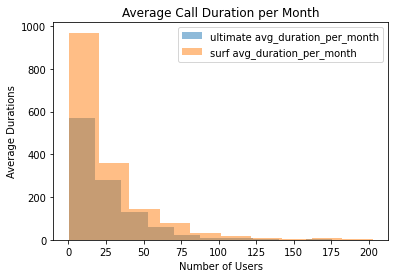

In [30]:
# Compare average duration of calls per each plan per each distinct month. Plot a bar plat to visualize it.

users_call_df = users_df.merge(calls_df).rename({"call_id":"id"}, axis=1)
users_call_pivot = pd.DataFrame(users_call_df.pivot_table(index=['user_id', 'month'], values='duration', aggfunc=['count', 'sum'])).reset_index(drop=False)
users_call_pivot.columns = ['user_id', 'call_month', 'count_calls', 'total_duration']
display(users_call_pivot.sample(5))


months = 12
complete_merge['duration_per_month'] = users_call_pivot['total_duration']
complete_merge['avg_duration_per_month'] = users_call_pivot['total_duration'] / months
duration_metrics = {'avg_duration_per_month' : 'minutes per month'}

def generate_duration_plot(df, metrics = duration_metrics):
    surf = complete_merge[complete_merge['plan_name'] == 'surf']
    ultimate = complete_merge[complete_merge['plan_name'] == 'ultimate']
    for col, title in metrics.items():
        plt.hist(ultimate[col], alpha=0.5, label=f'ultimate {col}')
        plt.hist(surf[col], alpha=0.5, label=f'surf {col}')
        plt.legend(loc='upper right')
        plt.title('Average Call Duration per Month')
        plt.xlabel('Number of Users')
        plt.ylabel('Average Durations')
        plt.show()
        
generate_duration_plot(complete_merge)

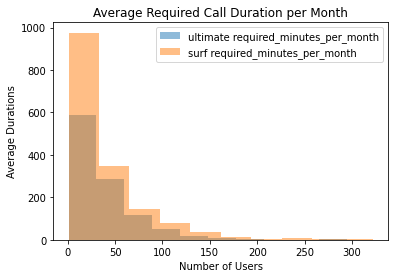

In [31]:
# Compare the number of minutes users of each plan require each month. Plot a histogram.

complete_merge['required_minutes_per_month'] = users_call_pivot['count_calls']
required_minutes_metrics = {'required_minutes_per_month' : 'minutes per month'}

def generate_duration_plot(df, metrics = required_minutes_metrics):
    surf = complete_merge[complete_merge['plan_name'] == 'surf']
    ultimate = complete_merge[complete_merge['plan_name'] == 'ultimate']
    for col, title in metrics.items():
        plt.hist(ultimate[col], alpha=0.5, label=f'ultimate {col}')
        plt.hist(surf[col], alpha=0.5, label=f'surf {col}')
        plt.legend(loc='upper right')
        plt.title('Average Required Call Duration per Month')
        plt.xlabel('Number of Users')
        plt.ylabel('Average Durations')
        plt.show()
        
generate_duration_plot(complete_merge) 

In [32]:
# Calculate the mean and the variance of the monthly call duration
display(complete_merge['duration_per_month'].describe())
call_duration_std = 307.569962
call_duration_var = np.sqrt(call_duration_std)
display(call_duration_var)


count    2702.000000
mean      285.066987
std       307.569962
min         1.000000
25%        81.000000
50%       187.000000
75%       385.000000
max      2432.000000
Name: duration_per_month, dtype: float64

17.537672650611313

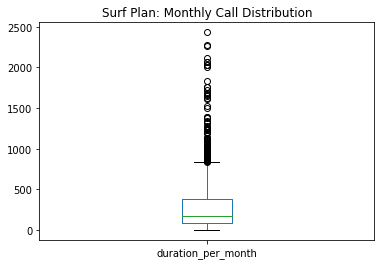

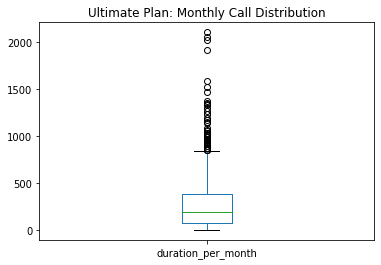

In [33]:
# Plot a boxplot to visualize the distribution of the monthly call duration

complete_merge[complete_merge['plan_name'] == 'surf']['duration_per_month'].plot(kind = 'box')
plt.title('Surf Plan: Monthly Call Distribution')
plt.show()
complete_merge[complete_merge['plan_name'] == 'ultimate']['duration_per_month'].plot(kind = 'box')
plt.title('Ultimate Plan: Monthly Call Distribution')
plt.show()

The distribution in terms of calling between the two plans is very similar. They are both positively skewed with similar median values.

### Messages

,user_id,message_month,message_count
405,1114,10,89
697,1188,12,52
1599,1438,12,55
1389,1372,12,54
985,1259,5,29


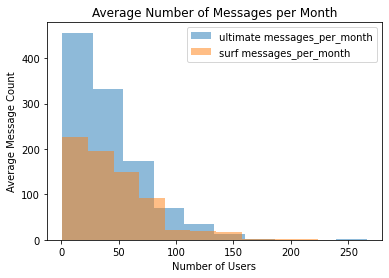

In [34]:
# Compare the number of messages users of each plan tend to send each month
users_messages = users_df.merge(messages_df).rename({"message_id":"id"}, axis=1)

users_messages_pivot = pd.DataFrame(users_messages.pivot_table(index=['user_id', 'month'], values='id', aggfunc=['count'])).reset_index(drop=False)
users_messages_pivot.columns = ['user_id', 'message_month', 'message_count']
display(users_messages_pivot.sample(5))


complete_merge['messages_per_month'] = users_messages_pivot['message_count']
message_metrics = {'messages_per_month' : 'messages per month'}

def generate_message_plot(df, metrics = message_metrics):
    surf = complete_merge[complete_merge['plan_name'] == 'surf']
    ultimate = complete_merge[complete_merge['plan_name'] == 'ultimate']
    for col, title in metrics.items():
        plt.hist(ultimate[col], alpha=0.5, label=f'ultimate {col}')
        plt.hist(surf[col], alpha=0.5, label=f'surf {col}')
        plt.legend(loc='upper right')
        plt.title('Average Number of Messages per Month')
        plt.xlabel('Number of Users')
        plt.ylabel('Average Message Count')
        plt.show()
        
generate_message_plot(complete_merge)

In [35]:
display(complete_merge['messages_per_month'].describe())
call_duration_std = 33.122931
call_duration_var = np.sqrt(call_duration_std)
display(call_duration_var)

count    1806.000000
mean       42.110188
std        33.122931
min         1.000000
25%        17.000000
50%        34.000000
75%        59.000000
max       266.000000
Name: messages_per_month, dtype: float64

5.755252470569818

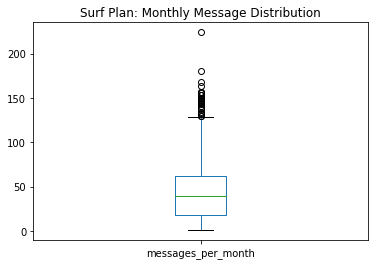

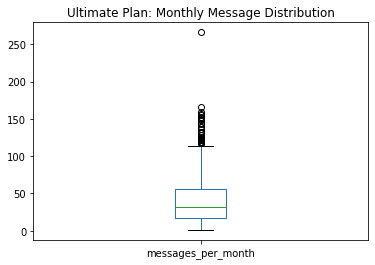

In [36]:
complete_merge[complete_merge['plan_name'] == 'surf']['messages_per_month'].plot(kind = 'box')
plt.title('Surf Plan: Monthly Message Distribution')
plt.show()
complete_merge[complete_merge['plan_name'] == 'ultimate']['messages_per_month'].plot(kind = 'box')
plt.title('Ultimate Plan: Monthly Message Distribution')
plt.show()

Again, both are positively skewed but the quartiles for the Surf plan are wider that the Ultimate plan. The histogram shows that users enrolled into the Ultimate plan usually send more messages per month than those enrolled in the Surf plan.

### Internet

,user_id,session_month,mb_count
599,1127,9,83
210,1050,9,56
1190,1252,12,46
647,1137,12,16
244,1056,11,65


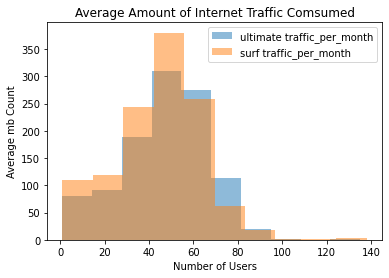

In [37]:
# Compare the amount of internet traffic consumed by users per plan
users_internet = users_df.merge(internet_df).rename({"session_id":"id"}, axis=1)

users_internet_pivot = pd.DataFrame(users_internet.pivot_table(index=['user_id', 'month'], values='id', aggfunc=['count'])).reset_index(drop=False)
users_internet_pivot.columns = ['user_id', 'session_month', 'mb_count']
display(users_internet_pivot.sample(5))


complete_merge['traffic_per_month'] = users_internet_pivot['mb_count']
traffic_metrics = {'traffic_per_month' : 'internet traffice per month'}

def generate_internet_traffic_plot(df, metrics = traffic_metrics):
    surf = complete_merge[complete_merge['plan_name'] == 'surf']
    ultimate = complete_merge[complete_merge['plan_name'] == 'ultimate']
    for col, title in metrics.items():
        plt.hist(ultimate[col], alpha=0.5, label=f'ultimate {col}')
        plt.hist(surf[col], alpha=0.5, label=f'surf {col}')
        plt.legend(loc='upper right')
        plt.title('Average Amount of Internet Traffic Comsumed')
        plt.xlabel('Number of Users')
        plt.ylabel('Average mb Count')
        plt.show()
        
generate_internet_traffic_plot(complete_merge)

In [38]:
display(complete_merge['traffic_per_month'].describe())
internet_traffic_std = 19.275885
internet_traffic_var = np.sqrt(internet_traffic_std)
display(internet_traffic_var)

count    2277.000000
mean       46.036451
std        19.275885
min         1.000000
25%        35.000000
50%        48.000000
75%        58.000000
max       138.000000
Name: traffic_per_month, dtype: float64

4.390431072229696

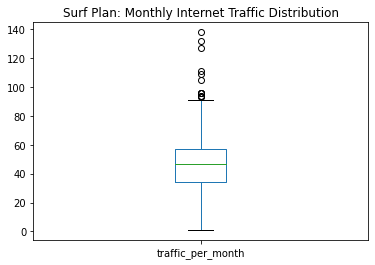

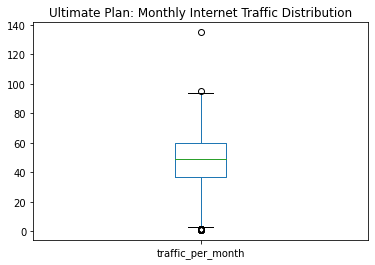

In [39]:
complete_merge[complete_merge['plan_name'] == 'surf']['traffic_per_month'].plot(kind = 'box')
plt.title('Surf Plan: Monthly Internet Traffic Distribution')
plt.show()
complete_merge[complete_merge['plan_name'] == 'ultimate']['traffic_per_month'].plot(kind = 'box')
plt.title('Ultimate Plan: Monthly Internet Traffic Distribution')
plt.show()

When it comes to internet traffic, both plans are pretty symmetrical when it comes to their skew with few outliers. The medians are pretty similar along with their quartiles. The histogram shows that users from both plans peak between 40 and 60. 

## Revenue

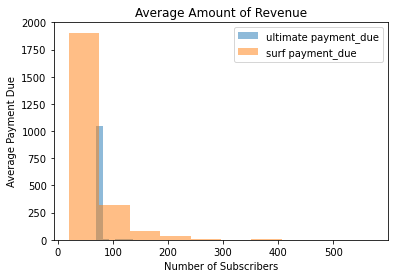

In [40]:
payment_metrics = {'payment_due' : 'monthly payment due'}

def generate_payment_due_plot(df, metrics = payment_metrics):
    surf = complete_merge[complete_merge['plan_name'] == 'surf']
    ultimate = complete_merge[complete_merge['plan_name'] == 'ultimate']
    for col, title in metrics.items():
        plt.hist(ultimate[col], alpha=0.5, label=f'ultimate {col}')
        plt.hist(surf[col], alpha=0.5, label=f'surf {col}')
        plt.legend(loc='upper right')
        plt.title('Average Amount of Revenue')
        plt.xlabel('Number of Subscribers')
        plt.ylabel('Average Payment Due')
        plt.show()
        
generate_payment_due_plot(complete_merge)

In [41]:
display(complete_merge['payment_due'].describe())
payment_due_std = 42.520180
payment_due_var = np.sqrt(payment_due_std)
display(payment_due_var)

count    3441.000000
mean       54.898204
std        42.520180
min        20.000000
25%        20.000000
50%        54.200000
75%        70.000000
max       572.280000
Name: payment_due, dtype: float64

6.520749956868459

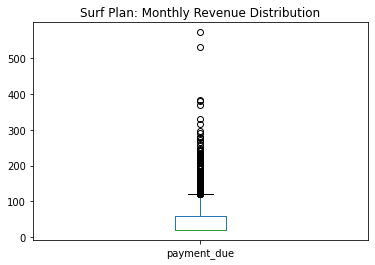

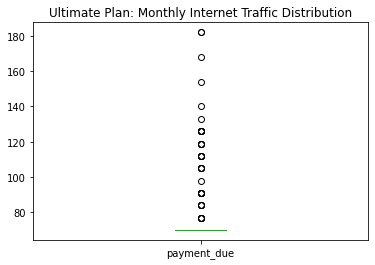

In [42]:
complete_merge[complete_merge['plan_name'] == 'surf']['payment_due'].plot(kind = 'box')
plt.title('Surf Plan: Monthly Revenue Distribution')
plt.show()
complete_merge[complete_merge['plan_name'] == 'ultimate']['payment_due'].plot(kind = 'box')
plt.title('Ultimate Plan: Monthly Internet Traffic Distribution')
plt.show()

Comparing the two plans and their revenue, it seems that the Surf plan is generating more revenue.

## Test statistical hypotheses

[Test the hypothesis that the average revenue from users of the Ultimate and Surf calling plans differs.]

Null Hypothesis: The average revenue from users of the Ultimate and Surf calling plans are similar.

Alternative Hypothesis: The average revenue from users of the Ultimate and Surf calling plans are different.

In [43]:
# Test the hypotheses
ultimate = complete_merge[complete_merge['plan_name'] == 'ultimate']['payment_due'].dropna()
surf = complete_merge[complete_merge['plan_name'] == 'surf']['payment_due'].dropna()

def check_f_test(X,Y):
  F = np.var(X) / np.var(Y)
  p_value = f_test.cdf(F, len(X)-1, len(Y)-1)
  return p_value > .05

In [44]:
if check_f_test(ultimate, surf):
    print('Could not reject the null hypothesis, therefore that Var(ultimate) == Var(surf)')
else:
    print('There is significance to reject the null hypothesis, therefore Var(ultimate) != Var(surf)')
    

results = st.ttest_ind(ultimate, surf, equal_var=True)
print(results.pvalue)
if results.pvalue < .05:
      print('Reject the null hypothesis, therefore the average profits for plans are different')
else:
      print('Fail in rejecting of the null hypothesis, therefore the average profits for plans are the same')

There is significance to reject the null hypothesis, therefore Var(ultimate) != Var(surf)
2.6588772443393235e-56
Reject the null hypothesis, therefore the average profits for plans are different


[Test the hypothesis that the average revenue from users in the NY-NJ area is different from that of the users from the other regions.]

Null Hypothesis: The average revenue from users in the NY-NJ area are similar to that of users from the other regions.

Alternative Hypothesis: The average revenue from users in the NY-NJ area are different to that of users from the other regions.

In [45]:
# Test the hypotheses
complete_merge[['cities', 'state_area']] = complete_merge['city'].apply(
    lambda x: pd.Series(str(x).split(',')))
display(complete_merge['state_area'].unique())

array([' GA MSA', ' CA MSA', ' FL MSA', ' OH MSA', ' TN MSA', ' TX MSA',
       ' PA-NJ-DE-MD MSA', ' IL-IN-WI MSA', ' NY-NJ-PA MSA', ' AL MSA',
       ' OK MSA', ' CO MSA', ' WA MSA', ' NV MSA', ' IN MSA', ' SC MSA',
       ' NC-SC MSA', ' AZ MSA', ' MI MSA', ' CT MSA', ' OH-KY-IN MSA',
       ' VA-NC MSA', ' KY-IN MSA', ' VA MSA', ' MO-IL MSA', ' MN-WI MSA',
       ' LA MSA', ' TN-MS-AR MSA', ' PA MSA', ' DC-VA-MD-WV MSA',
       ' UT MSA', ' OR-WA MSA', ' MA-NH MSA', ' NE-IA MSA', ' NM MSA',
       ' NY MSA', ' RI-MA MSA', ' HI MSA', ' MD MSA', ' WI MSA',
       ' MO-KS MSA', ' NC MSA'], dtype=object)

In [46]:
complete_merge['is_NY_NJ_area'] = complete_merge['city'].str.contains('NY-NJ')

NY_NJ = complete_merge[complete_merge['is_NY_NJ_area']]['payment_due'].dropna()
not_NY_NJ = NY_NJ = complete_merge[~complete_merge['is_NY_NJ_area']]['payment_due'].dropna()

if check_f_test(NY_NJ, not_NY_NJ):
    print('There is significance to reject the null hypothesis')   
else:
    print('Failed to reject the null hypothesis')
    
    
results = st.ttest_ind(NY_NJ, not_NY_NJ, equal_var=True)
if results.pvalue < .05:
      print('we have sufficient significance for rejecting the null hypothesis, therefore the avg profits comparing for two population in NY/NJ area are not are different')
        
else:
      print('Fail in rejecting of the null hypothesis, therefore the avg profits comparing for two population in NY/NJ area are not are the same')

There is significance to reject the null hypothesis
Fail in rejecting of the null hypothesis, therefore the avg profits comparing for two population in NY/NJ area or not are the same


## General conclusion

Comparing users enrolled in Megaline’s two plans, Surf and Ultimate, we can see several similarities and differences. In terms of calling, users in both seem to be pretty similar in their distribution of call duration per month. Internet traffic per month for users in both plans is also very similar to each other. When comparing the average payments per month for users in both plans, the users enrolled into the Surf plan has a wider range of payment amount compared to those enrolled in the Ultimate plan.

When testing the hypothesis that the average revenue from Users of the Ultimate and Surf calling plans differ, we found that we can reject the null hypothesis because the average profits for the plans are different.

When testing the hypothesis that the average revenue from users in the NY-NJ area is different from that of the users from the other regions, we found that we cannot reject the null hypothesis as the average profits comparing the two populations in the NY/NJ area are not the same.
